## Fraud detection using PySpark
### Autor: Antonio Castañares Rodríguez, A20599898
### CS 597: Reading and Special Problems

In [0]:
%pip install xgboost==1.7.6

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession, functions 
from pyspark.sql.functions import col, sum, year
from pyspark.sql.types import StringType, DoubleType, IntegerType, LongType
from pyspark.sql.functions import concat_ws
from xgboost.spark import SparkXGBClassifier
from synapse.ml.lightgbm import LightGBMClassifier

In [0]:
'''
    Name: get_columns
    Input: Dataframe and boolean
    Output: Name of numeric or categorical columns
    Description: This function returns the name of numeric or categorical columns from the dataset
    based on the value of numerical.
'''
def get_columns(df, numerical=True):
    if numerical:
        result = [field.name for field in df.schema
                  if isinstance(field.dataType, (IntegerType, DoubleType, LongType))]
    else:
        result = [field.name for field in df.schema
                  if isinstance(field.dataType, StringType)]
    return result

'''
    Name: plotting_confusion_matrix
    Input: Dataframe and numeric column to plot
    Output: None
    Description: This function prints the confusion matrix and the numerical columns for it
'''
def plotting_correlation_matrix(df):
    # Extract the numerical columns
    numerical_columns = [col for col in get_columns(df)]
    print(f'Numerical columns: {numerical_columns}')

    # combines numerical columns into a vector
    vector_assembler = VectorAssembler(inputCols=numerical_columns, outputCol='features_vector')
    df_vectorized = vector_assembler.transform(df)

    # Calculate correlations and plot the matrix
    correlation_matrix = Correlation.corr(df_vectorized, 'features_vector', method='pearson').head()[0].toArray()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
    ax = plt.gca()
    ax.set_xticklabels(numerical_columns, rotation=45, ha='right')
    ax.set_yticklabels(numerical_columns, rotation=0)
    plt.title('Correlation Matrix')
    plt.show()

#### Fraud detection using Spark

This project focuses on detecting fraudulent transactions using PySpark. Fraud detection is a classic classification problem in data science, and it's particularly challenging due to the severe class imbalance between fraudulent.

The dataset used in this project is synthetically generated using the Sparkov Data Generation project. It simulates realistic transactional data, including user behaviors and fraud patterns. The decision to choose this dataset is based on the fact that it is the only one that contains a sufficient volume of data to justify the use of PySpark. Other datasets do not have enough data to make using PySpark worthwhile. This dataset contains 1.3 million rows and 23 features.

Main features in the dataset:
- trans_date_trans_time: Timestamp of the transaction.
- cc_num: Credit card number (anonymized).
- merchant: Name of the merchant where the transaction occurred.
- category: Type/category of the merchant (e.g., gas_transport, grocery_pos, etc.).
- amt: Transaction amount in USD.
- first: First name of the cardholder.
- last: Last name of the cardholder.
- gender: Gender of the cardholder.
- street: Street address of the cardholder.
- city: City of the cardholder.
- state: State of the cardholder.
- zip: ZIP code of the cardholder.
- lat: Latitude of the cardholder’s address.
- long: Longitude of the cardholder’s address.
- city_pop: Population of the cardholder’s city.
- job: Job title of the cardholder.
- dob: Date of birth of the cardholder.
- trans_num: Unique transaction ID.
- unix_time: Timestamp in Unix time.
- merch_lat: Latitude of the merchant’s location.
- merch_long: Longitude of the merchant’s location.
- is_fraud: Target variable: 1 if fraudulent, 0 otherwise.

Let's load the training and testing datasets. The data was split using a 70/30 ratio, resulting in 1,296,675 samples for training and 555,719 for testing. Both datasets contain 23 features.

In [0]:
# Load both datasets
df_train = spark.read.csv('/FileStore/tables/fraudTrain.csv', header=True, inferSchema=True)
df_test = spark.read.csv('/FileStore/tables/fraudTest.csv', header=True, inferSchema=True)

# Create Temporary views for SQL queries
df_train.createOrReplaceTempView('sql_train')
df_test.createOrReplaceTempView('sql_test')

# Number of samples
n_train_samples = df_train.count()
n_test_samples = df_test.count()
print(f'Number of samples in training dataset: {n_train_samples}')
print(f'Number of samples in testing dataset: {n_test_samples}')
print(f'Percentaje of split: {n_train_samples / (n_train_samples + n_test_samples) * 100:.2f}%')

Number of samples in training dataset: 1296675
Number of samples in testing dataset: 555719
Percentaje of split: 70.00%


In [0]:
df_train.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [0]:
df_train.show()

+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|_c0|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|
+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|  0|  2019-01-01 00:00:18|   2703186189

In [0]:
df_train.describe().show()

+-------+-----------------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+-----------------+------------------+--------------------+
|summary|              _c0|              cc_num|           merchant|     category|              amt|  first|   last| gender|              street|   city|  state|               zip|               lat|              long|          city_pop|               job|           trans_num|           unix_time|        merch_lat|        merch_long|            is_fraud|
+-------+-----------------+--------------------+-------------------+-------------+-----------------+-------+-------+-------+--------------------+-------+-------+------------------+------------------+------------------+------------------+------------------+--------------------+---------

Conclusions about the statistical summary of the training dataset:

- All columns have the same count, indicating there are no missing values in the dataset.
- The feature amt (transaction amount) has a mean of 70.35 and a high standard deviation (160.32). This suggest that fraudulent a wide range of transaction amount. Also the high ranges from 1.0 to 28948.9 confirms this significant variability.
- The target feature (is_fraud) has a very low mean (0.0058), suggesting that fraudulent transactions are rare.

Let's confirm possible missing values in the dataset. We should not find any missing value. However, if we find any missing value we can follow the next approaches:

- Drop the row: Not recommendated because we loss information.
- Drop the column: Only recommendated if missing values represents an important part of the feature.
- Impute using mean or mode (using Imputer from MLlib): Depending of the feature could be interesting. 
- Other approaches like KNN are not native in Spark, therefore they are not taking in count.

In [0]:
print('Missing values in training set:')
df_train.select([sum(col(c).isNull().cast('int')).alias(c) for c in df_train.columns]).show()
print('Missing values in test set:')
df_test.select([sum(col(c).isNull().cast('int')).alias(c) for c in df_test.columns]).show()

Missing values in training set:
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|_c0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|  0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+

Missing values in test set:
+---+---------------------+------+--------+--------+---+-----+----+------+

This dataset is complete, as there are not missing values. Now, I will check the distribution of the dataset. It is common in fraud detection to deal with imbalanced datasets. 

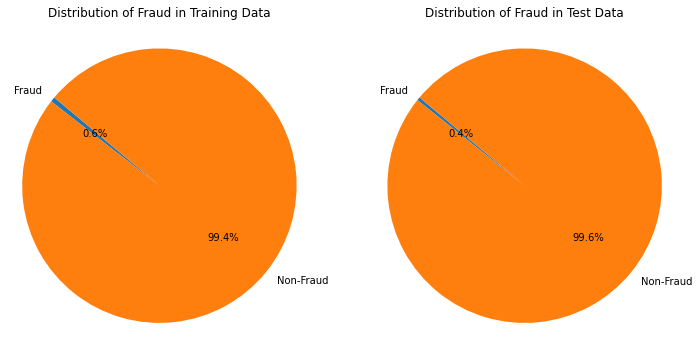

Number of frauds in training data: 7506
Number of non-frauds in training data: 1289169
Number of frauds in test data: 2145
Number of non-frauds in test data: 553574


In [0]:
# Number of fraud and non fraud cases in both datasets
train_frauds = df_train.filter(df_train['is_fraud'] == 1).count()
train_non_frauds = df_train.count() - train_frauds
test_frauds = df_test.filter(df_test['is_fraud'] == 1).count()
test_non_frauds = df_test.count() - test_frauds

# Distribution plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie([train_frauds, train_non_frauds], labels=['Fraud', 'Non-Fraud'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fraud in Training Data')
plt.axis('equal') 
plt.subplot(1, 2, 2)
plt.pie([test_frauds, test_non_frauds], labels=['Fraud', 'Non-Fraud'], autopct='%1.1f%%', startangle=140)	
plt.title('Distribution of Fraud in Test Data')
plt.axis('equal')  
plt.show()

print(f'Number of frauds in training data: {train_frauds}')
print(f'Number of non-frauds in training data: {train_non_frauds}')
print(f'Number of frauds in test data: {test_frauds}')
print(f'Number of non-frauds in test data: {test_non_frauds}')

The dataset is clearly imbalanced. I decided instead of changing the data distribution (like undersampling or oversampling), we adjust the loss function to misclassifying a fraud (minority) is penalized more than misclassifying a non-fraud (majority). This will be done in following sections.

##### Numerical features

In this section, I will perform feature engineering to create new features and evaluate the relevance of existing numerical features by analyzing their correlation values with the target variable.

I'm going to start getting the age based on the date of birth (dob) which is in the format YYYY-MM-DD, so we can extract the year from it and calculate the age by subtracting it from the transaction year. We must not use the current year, as we want to avoid data leakage (uses information that wouldn't be available at the time of prediction).

In [0]:
# We applied transaction_year - year of birth
df_train = df_train.withColumn('age', 
                               (year(col('trans_date_trans_time')) - col('dob').substr(1, 4)
                                .cast(IntegerType())))                        
df_test = df_test.withColumn('age', 
                             (year(col('trans_date_trans_time')) - col('dob').substr(1, 4)
                              .cast(IntegerType())))                                        

df_train.select('age').describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|           1296675|
|   mean| 46.02929801222357|
| stddev|17.382372624741294|
|    min|                14|
|    max|                96|
+-------+------------------+



Now, I will calculate the distance between the customer and the merchant in order to detect unusual behaviours. The features lat, long, merch_lat, and merch_long can be combined by calculating the distance between the customer and the merchant. The distance is computed using the following formula:
$$
\text{Distance between } (x_1,y_1) \text{ and } (x_2, y_2) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
$$

In [0]:
# Extract the distance between the customer and the merchant, using withColumns creates
# a new column in each dataset which will store the distance.
df_train = df_train.withColumn(
    'distance_customer_merchant',
    functions.sqrt(
        (functions.col('lat') - functions.col('merch_lat')) ** 2 +
        (functions.col('long') - functions.col('merch_long')) ** 2
    )
)

df_test = df_test.withColumn(
    'distance_customer_merchant',
    functions.sqrt(
        (functions.col('lat') - functions.col('merch_lat')) ** 2  +
        (functions.col('long') - functions.col('merch_long')) ** 2 
    )
)

df_train.select('distance_customer_merchant').describe().show()

+-------+--------------------------+
|summary|distance_customer_merchant|
+-------+--------------------------+
|  count|                   1296675|
|   mean|        0.7656610714225193|
| stddev|        0.2847484245847595|
|    min|      2.386629422352145...|
|    max|        1.4133643382726842|
+-------+--------------------------+



I capture the typical spending behavior of each user, merchant, and category by grouping transactions based on credit card number (cc_num), category, and merchant, and calculating the average transaction amount for each group. These averages are computed using only the training dataset to avoid data leakage. For any new users, merchants, or categories that appear in the test set (and thus lack these averages), I replace the missing values with 1 to ensure consistency.

In [0]:
# Extract the amount average per user
user_amt_avg = df_train.groupBy("cc_num").agg(
    functions.mean("amt").alias("user_amt_avg")
)

# Extract the amount average per category
category_amt_avg = df_train.groupBy('category').agg(
    functions.mean('amt').alias('category_amt_avg')
)

# Extract the amount average per merchant
merchant_amt_avg = df_train.groupBy('merchant').agg(
    functions.mean('amt').alias('merchant_amt_avg')
)

# Adding information into both dataset, creading a new column called by each alias
df_train = df_train.join(user_amt_avg, on="cc_num", how="left")
df_test = df_test.join(user_amt_avg, on="cc_num", how="left")
df_train = df_train.join(category_amt_avg, on="category", how="left")
df_test = df_test.join(category_amt_avg, on="category", how="left")
df_train = df_train.join(merchant_amt_avg, on="merchant", how="left")
df_test = df_test.join(merchant_amt_avg, on="merchant", how="left")

# New users in the test dataset, replace missing values by 1
df_test = df_test.fillna({'user_amt_avg': 1})
df_test = df_test.fillna({'category_amt_avg': 1})
df_test = df_test.fillna({'merchant_amt_avg': 1})

# Finally, I calculated the relative amount per user (amt/user amt average)
df_train = df_train.withColumn('relative_amt', functions.col('amt') / functions.col('user_amt_avg'))
df_test = df_test.withColumn('relative_amt', functions.col('amt') / functions.col('user_amt_avg'))

df_train.select('user_amt_avg','category_amt_avg','merchant_amt_avg', 'relative_amt').describe().show()

+-------+------------------+------------------+------------------+--------------------+
|summary|      user_amt_avg|  category_amt_avg|  merchant_amt_avg|        relative_amt|
+-------+------------------+------------------+------------------+--------------------+
|  count|           1296675|           1296675|           1296675|             1296675|
|   mean| 70.35103545607805| 70.35103545603657|   70.351035456073|  1.0000000000000024|
| stddev|19.410290693894147|  20.6279472733389|20.962541663501693|  2.2999175032629178|
|    min|  42.9516710013004| 47.96767811102054| 45.84807986870898|0.008693368698356895|
|    max| 948.8181818181819|116.96098594283319| 165.6534771573604|   386.4815882611676|
+-------+------------------+------------------+------------------+--------------------+



Next, I compute the total number of transactions per user because a higher-than-normal number of transactions can be a strong indicator of suspicious behavior. I also ensure that in the test set, if a completely new user appears (because it has not seen in training), I assign a default value of 1 to avoid introducing nulls into the feature.


In [0]:
# Extract the number of transactions per user
user_transactions_train = df_train.groupBy('cc_num').agg(
    functions.count('*').alias('transactions_per_user')
)
# Adding information to both datasets
df_train = df_train.join(user_transactions_train, on='cc_num', how='left')
df_test = df_test.join(user_transactions_train, on='cc_num', how='left')

# Replace transactions per user of a new user in the test dataset by 1
df_test = df_test.fillna({'transactions_per_user': 1})

Finally, I will extract the hour of each transaction using the "unix_time" feature, which records the number of seconds elapsed since January 1, 1970, at 00:00:00 UTC. Additionally, I will determine the day of the week for each transaction and identify whether it occurred at night, defining nighttime as between 8 PM and 8 AM.

In [0]:
# Convert unix_time into Timestamp
df_train = df_train.withColumn('transaction_timestamp', functions.from_unixtime('unix_time'))
df_test = df_test.withColumn('transaction_timestamp', functions.from_unixtime('unix_time'))

# Extract the hour 
df_train = df_train.withColumn('transaction_hour', functions.hour('transaction_timestamp'))
df_test = df_test.withColumn('transaction_hour', functions.hour('transaction_timestamp'))

# Extract the day
df_train = df_train.withColumn('day_of_week',functions.dayofweek('transaction_timestamp'))
df_test = df_test.withColumn('day_of_week',functions.dayofweek('transaction_timestamp'))

# Extract whether it occured at night (from 8PM to 8 AM)
df_train = df_train.withColumn('is_night',
                               functions.when((functions.col('transaction_hour') < 8) | (functions.col('transaction_hour') > 22), 1)
                               .otherwise(0))
df_test = df_test.withColumn('is_night',
                             functions.when((functions.col('transaction_hour') < 8) | (functions.col('transaction_hour') > 22), 1)
                             .otherwise(0))

df_train.select('transaction_hour','day_of_week','is_night').describe().show()

+-------+------------------+------------------+-------------------+
|summary|  transaction_hour|       day_of_week|           is_night|
+-------+------------------+------------------+-------------------+
|  count|           1296675|           1296675|            1296675|
|   mean|12.804857809397111| 4.183884936472131| 0.3134455434091041|
| stddev| 6.817823899187159|2.1962103879706856|0.46389395413948653|
|    min|                 0|                 1|                  0|
|    max|                23|                 7|                  1|
+-------+------------------+------------------+-------------------+



I will drop the features related to location (since our new feature 'distance_customer_merchant' captures that information) as well as unique identifiers for each transaction (such as '_c0' and 'cc_num'), which do not contribute useful patterns for modeling.

In [0]:
df_train = df_train.drop('lat','long','merch_lat','merch_long','dob','_c0','cc_num')
df_test = df_test.drop('lat','long','merch_lat','merch_long','dob','_c0','cc_num')

Numerical columns: ['amt', 'zip', 'city_pop', 'unix_time', 'is_fraud', 'age', 'distance_customer_merchant', 'user_amt_avg', 'category_amt_avg', 'merchant_amt_avg', 'relative_amt', 'transactions_per_user', 'transaction_hour', 'day_of_week', 'is_night']


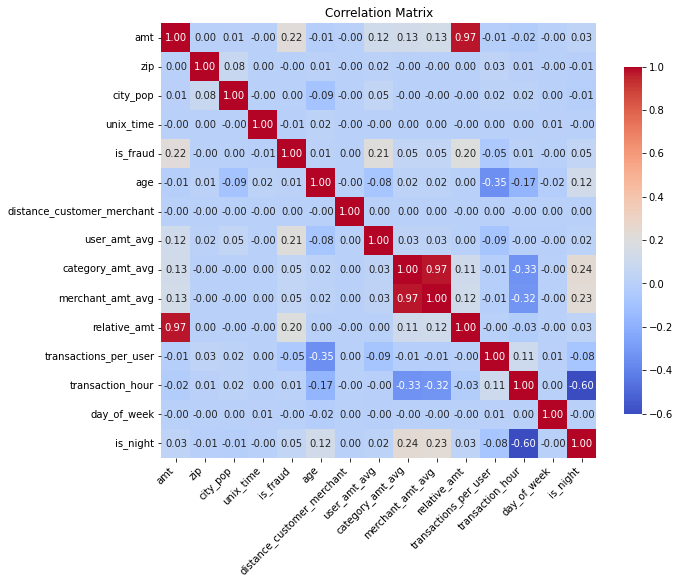

In [0]:
plotting_correlation_matrix(df_train)

Correlation matrix conclusion:

- 'amt', 'user_amt_avg', 'category_amt_avg', 'merchant_amt_avg', 'relative_amt', 'transaction_hour' and 'is_night' are the only variables moderately correlated with is_fraud.
- 'category_amt_avg' will be excluded from the model because it is highly correlated with 'merchant_amt_avg', indicating they capture similar information.
- 'relative_amt' will be excluded because of its strong correlation with 'amt', suggesting redundancy between them.
- 'is_night' will not be included, as I prefer to keep 'transaction_hour', which is more general and provides richer temporal detail.
- Other variables show very low or no correlation with is_fraud, suggesting they are weakly predictive and they should not be included in our model.

In [0]:
numerical_columns = get_columns(df_train)
# Remove 'amt', is_fraud', 'user_avg_amt', 'transaction_hour' and 'merchant_amt_avg' from numerical_columns
numerical_columns.remove('amt')
numerical_columns.remove('is_fraud')
numerical_columns.remove('user_amt_avg')
numerical_columns.remove('transaction_hour')
numerical_columns.remove('merchant_amt_avg')
numerical_columns.remove('age')

# Drop the rest numerical columns from df_train and df_test
df_train = df_train.drop(*numerical_columns)
df_test = df_test.drop(*numerical_columns)

# Remove time-related columns 
df_train = df_train.drop('trans_date_trans_time')
df_test = df_test.drop('trans_date_trans_time')
df_train = df_train.drop('unix_time')
df_test = df_test.drop('unix_time')
df_train = df_train.drop('transaction_timestamp')
df_test = df_test.drop('transaction_timestamp')

##### Categorical features

Let's continue checking the categorical values in the dataset. Depending on the number of unique values and the meaning of the feature, next approaches can be considerated:

- Dropping: For insignifican features.
- StringIndexer: It transforms categorical variables into numerical indices. Other approaches, such as OneHotEncoding, are not considered because tree-based models can naturally handle indexed categorical features without requiring one-hot encoding.


In [0]:
categorical_columns = get_columns(df_train,numerical=False)
print(f'Categorical columns: {categorical_columns}')

Categorical columns: ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'trans_num']


In [0]:
for col_name in categorical_columns:
    print(f'Unique values in {col_name}: {df_train.select(col_name).distinct().count()}')

Unique values in merchant: 693
Unique values in category: 14
Unique values in first: 352
Unique values in last: 481
Unique values in gender: 2
Unique values in street: 983
Unique values in city: 894
Unique values in state: 51
Unique values in job: 494
Unique values in trans_num: 1296675


Let's analyze which categorical features may be interesting for your fraud detection model, based on their visualization

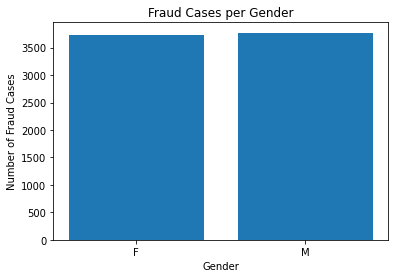

Number of fraud cases (female):3735
Number of fraud cases (men):3771


In [0]:
fraud_counts = df_train.filter(df_train['is_fraud'] == 1).groupBy('gender').count().collect()

genders = [row['gender'] for row in fraud_counts]
counts = [row['count'] for row in fraud_counts]

plt.figure(figsize=(6, 4))
plt.bar(genders, counts)
plt.xlabel('Gender')
plt.ylabel('Number of Fraud Cases')
plt.title('Fraud Cases per Gender')
plt.show()

print(f'Number of fraud cases (female):{counts[0]}')
print(f'Number of fraud cases (men):{counts[1]}')

Fraud cases is similar across genders, suggesting low predictive power. 

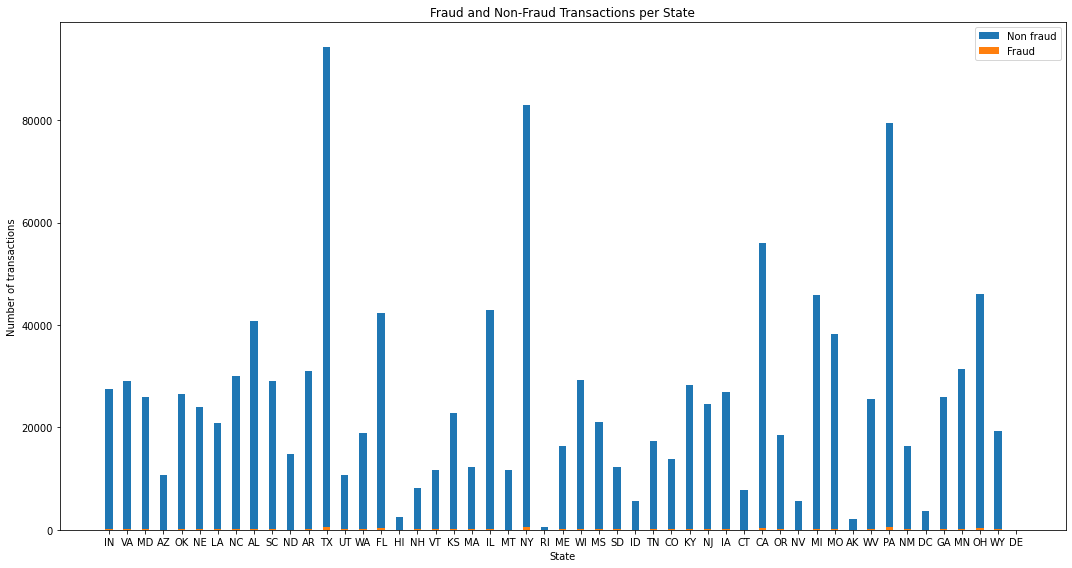

In [0]:
fraud_per_state = df_train.groupBy('state','is_fraud').count().collect()

fraud_counts = {}
non_fraud_counts = {}

for row in fraud_per_state:
    if row['is_fraud'] == 1:
        fraud_counts[row['state']] = row['count']
    else:
        non_fraud_counts[row['state']] = row['count']

plt.figure(figsize=(15,8))
plt.bar(non_fraud_counts.keys(), non_fraud_counts.values(),label='Non fraud',width=0.4)
plt.bar(fraud_counts.keys(), fraud_counts.values(),label='Fraud',width=0.4)
plt.xlabel('State')
plt.ylabel('Number of transactions')
plt.title('Fraud and Non-Fraud Transactions per State')
plt.legend()
plt.tight_layout()
plt.show()

The plot shows noticeable variation in both fraud and non-fraud transactions across different states, indicating potential predictive value.

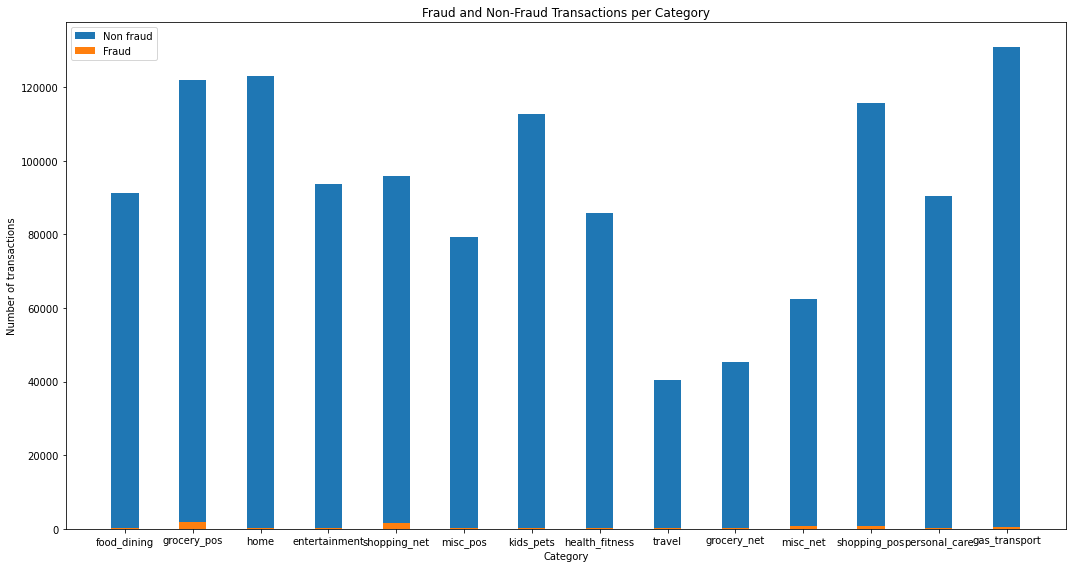

In [0]:
fraud_per_category = df_train.groupBy('category','is_fraud').count().collect()

fraud_counts = {}
non_fraud_counts = {}

for row in fraud_per_category:
    if row['is_fraud'] == 1:
        fraud_counts[row['category']] = row['count']
    else:
        non_fraud_counts[row['category']] = row['count']

plt.figure(figsize=(15,8))
plt.bar(non_fraud_counts.keys(), non_fraud_counts.values(),label='Non fraud',width=0.4)
plt.bar(fraud_counts.keys(), fraud_counts.values(),label='Fraud',width=0.4)
plt.xlabel('Category')
plt.ylabel('Number of transactions')
plt.title('Fraud and Non-Fraud Transactions per Category')
plt.legend()
plt.tight_layout()
plt.show()

We can observe that fraud is not uniformly distributed across categories. Some categories like grocery_pos, shopping_net, and misc_pos exhibit slightly higher counts of fraud relative to others, despite large volumes of non-fraud transactions. 

Based on the previous visualizations and the high cardinality observed in several categorical features, I decided to apply tailored preprocessing strategies for each case:

- merchant: I decided to apply StringIndexer.
- category: I decided to apply StringIndexer.
- First and Last: Firstly, I decided to mergen them and create 'full_name'.
- Gender: Dropped from the dataset, as the distribution of fraud cases was similar across genders, suggesting low predictive power.
- Street: I decided to drop it because it is over personalized. It does not make sense to keep it if I dropped numerical variables like 'lat' or 'long'.
- City: It does not make sense to keep it because it's too specific.
- State: I decided to keep it and apply StringIndexer. Some states are more common for fraud.
- Job: I decided to apply StringIndexer.
- trans_num: I decided to drop it because it does not add any information as it is an unique value for each case.

In [0]:
df_train = df_train.withColumn('full_name', concat_ws(' ', df_train['first'], df_train['last']))
df_test = df_test.withColumn('full_name', concat_ws(' ', df_test['first'], df_test['last']))

I will create risk-based features by calculating the fraud risk (mean of frauds) for each client, merchant, category, and job using the training data. These aggregated risk metrics are then joined back to both the training and test datasets to add contextual fraud risk information. To handle unseen categories in the test set, missing values are filled with a default of 1.

In [0]:
# Fraud risk based on users, merchants, categories, and jobs
client_risk_rate = df_train.groupBy('full_name').agg(functions.mean('is_Fraud').alias('client_risk_rate'))
merchant_risk_rate = df_train.groupBy('merchant').agg(functions.mean('is_Fraud').alias('merchant_risk_rate'))
category_risk_rate = df_train.groupBy('category').agg(functions.mean('is_fraud').alias('category_risk_rate'))
job_risk_rate = df_train.groupBy('job').agg(functions.mean('is_fraud').alias('job_risk_rate'))

# Adding information to both datasets
df_train = df_train.join(client_risk_rate,on='full_name',how='left')
df_train = df_train.join(merchant_risk_rate,on='merchant',how='left')
df_train = df_train.join(category_risk_rate,on='category',how='left')
df_train = df_train.join(job_risk_rate,on='job',how='left')

df_test = df_test.join(client_risk_rate,on='full_name',how='left')
df_test = df_test.join(merchant_risk_rate,on='merchant',how='left')
df_test = df_test.join(category_risk_rate,on='category',how='left')
df_test = df_test.join(job_risk_rate,on='job',how='left')

# Unseen cases are filled with 1
df_test = df_test.fillna({'client_risk_rate': 1})
df_test = df_test.fillna({'merchant_risk_rate': 1})
df_test = df_test.fillna({'category_risk_rate': 1})
df_test = df_test.fillna({'job_risk_rate': 1})

Now, let's combine all the previously engineered risk features into a single feature called transaction_risk, which aggregates the effects of client, merchant, category, and job risk. We compute it as the product of the log-transformed risk rates (I used log to make the distribution more balanced and easier for the model to learn from)

In [0]:
# Transaction_risk = client_risk * merchant_risk * category_risk * job_risk
# Remember log1p(x) = log(1 + x)
df_train = df_train.withColumn('transaction_risk', functions.log1p('client_risk_rate') *
                               functions.log1p('merchant_risk_rate') * functions.log1p('category_risk_rate')
                               * functions.log1p('job_risk_rate'))
df_test = df_test.withColumn('transaction_risk', functions.log1p('client_risk_rate') *
                               functions.log1p('merchant_risk_rate') * functions.log1p('category_risk_rate')
                               * functions.log1p('job_risk_rate'))

Now, let's see the correlation of our new features

Numerical columns: ['amt', 'is_fraud', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour', 'client_risk_rate', 'merchant_risk_rate', 'category_risk_rate', 'job_risk_rate', 'transaction_risk']


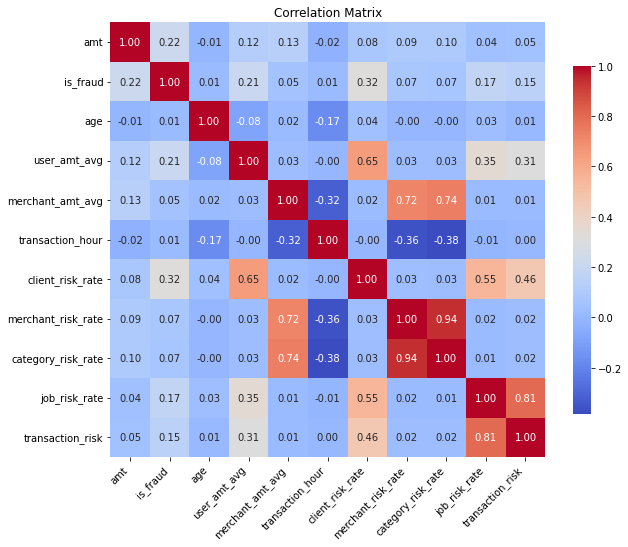

In [0]:
plotting_correlation_matrix(df_train)

Correlation matrix conclusion:

- 'client_risk_rate', 'job_risk_rate' and 'transaction_risk' have high correlation with 'user_amt_avg', for this reason I decided do not include them into the model.
- 'merchant_risk_rate' and 'category_risk_rate' have high correlation with ´merchant_amt_avg', therefore I decided do not include them into the model.

In [0]:
df_train = df_train.drop('first', 'last', 'street', 'city', 'trans_num','gender',
                        'category_risk_rate', 'merchant_risk_rate','client_risk_rate','job_risk_rate','transaction_risk')
df_test = df_test.drop('first', 'last', 'street', 'city', 'trans_num','gender',
                       'category_risk_rate', 'merchant_risk_rate','client_risk_rate','job_risk_rate','transaction_risk')

##### Pipeline preparation

I will implement the pipeline in this section. A pipeline is machine learning workflow by chaining together multiple stages like preprocessing, feature engineering, and model training. A Spark pipeline is made of two types of stages:

- Transformer: Transform the data into another. For numerical features, no transformation will be applied. Meanwhile, StringIndexer will be applied for categorical features.
- Estimator: It is our model as learns from our data.

In [0]:
# Get the input columns for our model
numerical_columns = get_columns(df_train)
categorical_columns = get_columns(df_train,numerical=False)

# Remove the target column from the input model
numerical_columns.remove('is_fraud')

print(f'Numerical_columns: {numerical_columns}')
print(f'Categorical_columns: {categorical_columns}')    
print(f'Final features: {numerical_columns + categorical_columns}\n')
print(f'Columns in training set: {df_train.columns}')
print(f'Columns in test set: {df_test.columns}')

Numerical_columns: ['amt', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour']
Categorical_columns: ['job', 'category', 'merchant', 'full_name', 'state']
Final features: ['amt', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour', 'job', 'category', 'merchant', 'full_name', 'state']

Columns in training set: ['job', 'category', 'merchant', 'full_name', 'amt', 'state', 'is_fraud', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour']
Columns in test set: ['job', 'category', 'merchant', 'full_name', 'amt', 'state', 'is_fraud', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour']


As we seen previously, our dataset is clearly imbalanced because 99.4 % of data belongs to one specific class. I decided to implement class weight to deal with this issue.

As we know, a pipeline is composed of transformers and estimators. In this case, the transformer applies StringIndexer to the categorical features and then merges the indexed features with the selected numerical features using the VectorAssembler. The behavior of StringIndexer is illustrated below:

$$
\text{StringIndexer}(
\begin{bmatrix}
Walmart \\
Target \\
Walmart \\
Starbucks
\end{bmatrix})
=
\begin{bmatrix}
0.0 \\
1.0 \\
0.0 \\
2.0
\end{bmatrix}
$$

The behavior of VectorAssembler is illustrated below:

$$
\text{VectorAssembler}(\text{'amt'}, \text{'distance\_customer\_merchant'}, \dots, \text{'job\_index\_index'})
=
\begin{bmatrix}
23.5 & 0.12 & \dots & 0.0 \\
10.5 & 0.2 & \dots & 1.0 \\
\vdots & \vdots & \vdots & \ddots \\
5.5 & 0.15 & \dots & 4.0
\end{bmatrix}
$$

Finally, I selected eXtreme Gradient Boosting (XGBoost) and LightGBM as the primary models due to their superior performance in structured data tasks compared to simpler models like Logistic Regression or Random Forest.

XGBoost is an optimized, high-performance implementation of gradient boosting that builds an ensemble of decision trees. It follows a boosting strategy where each new tree is trained to correct the errors of the previous ones. XGBoost supports parallel processing and efficient handling of large datasets, with extensive hyperparameter customization to adapt to specific problems.

On the other hand, LightGBM (Light Gradient Boosting Machine), developed by Microsoft, is a fast and scalable gradient boosting framework. It uses a histogram-based learning algorithm that significantly reduces training time and memory usage. LightGBM also supports GPU acceleration and distributed learning, making it ideal for large-scale machine learning tasks.

In order to improve our results, I decided to combine both models with Logistic Regression by using the predicted probabilities from each boosting model as additional input features for Logistic Regression. My idea is the second classifier could learn patterns that the base models missed, especially for borderline cases. This strategy allowed the Logistic Regression to refine the decision boundary based on richer, model-informed features. 

Based on these advantages, I designed four different pipelines combining both XGBoost and LightGBM to explore their strengths in the context of fraud detection.

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{XGB}
$$

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{lightGBM}
$$

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{XGB} \rightarrow \text{VectorAssembler} \rightarrow \text{Logistic Regression}
$$

$$
\text{Dataset} \rightarrow  \text{StringIndexer} (\text{for categorical}) \rightarrow \text{Merge numerical and categorical} \rightarrow \text{VectorAssembler} \rightarrow \text{GBM} \rightarrow \text{VectorAssembler} \rightarrow \text{Logistic Regression}
$$

In [0]:
# StringIndexers for categorical columns (convert categorical into numerical)
indexers = [
    StringIndexer(inputCol=col, outputCol=f'{col}_index', handleInvalid='keep')
    for col in categorical_columns
]

# Features for VectorAssembler
# - numerical columns stay as they are
# - categorical columns are replaced after apply StringIndexers
final_features = numerical_columns + [f'{col}_index' for col in categorical_columns]

# Assemble all features into 'features'
first_assembler = VectorAssembler(
                        inputCols=final_features,               # Name of the columns to be assembled (mumerical + categoricals_index)
                        outputCol='features'                    # Output column
)

# Assemble all features + probability calculated by XGB
xgb_assembler = VectorAssembler(
                        inputCols=['features', 'xgb_prob'],     # Columns to convert into a vector
                        outputCol='xgb_features'                # Output column

)

# Assemble all features + probability calculated by LightGBM
gbm_assembler = VectorAssembler(
                        inputCols=['features', 'gbm_prob'],     # Columns to convert into a vector
                        outputCol='gbm_features'                # Output column
)

# XGB Classifier
xgb = SparkXGBClassifier(
                        label_col='is_fraud',                   # Target column
                        features_col='features',                # Input for the model
                        scale_pos_weight=train_non_frauds 
                                        / train_frauds,         # Handle with imbalanced dataset, typically negative_samples/positive_samples
                        eta=0.1,                                # Learning rate (by default 0.3)          
                        num_round=200,                          # Number of iterations (by default 100)
                        prediction_col='xgb_pred',              # Predictions (probability calculated)
                        probability_col='xgb_prob',             # 1 if prediction >= 0.5 else 0
                        raw_prediction_col='xgb_raw'            # Confident interval
)
# LightGBM Classifier
gbm = LightGBMClassifier(
                        labelCol='is_fraud',                    # Target column
                        featuresCol='features',                 # Input for the model
                        isUnbalance=True,                       # Handle imbalanced dataset 
                        learningRate=0.05,                      # Learning rate
                        numIterations=300,                      # Number of iterations
                        numLeaves=64,
                        maxDepth=8,
                        predictionCol='gbm_prediction',         # Predictions (probability calculated)
                        probabilityCol='gbm_prob',              # 1 if prediction >= threshold else 0
                        rawPredictionCol='gbm_raw',             # Confident interval
)

# Logistic Regression classifier (standarize by default)
xgb_lr = LogisticRegression(
                        labelCol='is_fraud',                    # Target column
                        featuresCol='xgb_features',             # Input of the model
                        maxIter=100,                            # Maximum number of iterations
)

# Logistic Regression classifier (standarize by default)
gbm_lr = LogisticRegression(
                        labelCol='is_fraud',                    # Target column
                        featuresCol='gbm_features',             # Input of the model
                        maxIter=100,                            # Maximum number of iterations
                        threshold=0.2
)

print(f'Final features included in the model: {final_features}')

# Pipelines
xgb_pipeline = Pipeline(stages=indexers + [first_assembler, xgb])
gbm_pipeline = Pipeline(stages=indexers + [first_assembler, gbm])
xgb_lr_pipeline = Pipeline(stages=indexers + [first_assembler, xgb, xgb_assembler, xgb_lr])
gbm_lr_pipeline = Pipeline(stages=indexers + [first_assembler, gbm, gbm_assembler, gbm_lr])

Final features included in the model: ['amt', 'age', 'user_amt_avg', 'merchant_amt_avg', 'transaction_hour', 'job_index', 'category_index', 'merchant_index', 'full_name_index', 'state_index']


##### Model training and predictions

In [0]:
gbm_model = gbm_pipeline.fit(df_train)                      # Training the model
gbm_predictions = gbm_model.transform(df_test)              # Predictions based on the trained model

In [0]:
gbm_lr_model = gbm_lr_pipeline.fit(df_train)                # Training the model
gbm_lr_predictions = gbm_lr_model.transform(df_test)        # Predictions based on the trained model

In [0]:
xgb_model = xgb_pipeline.fit(df_train)                      # Training the model
xgb_predictions = xgb_model.transform(df_test)              # Predictions based on the trained model

In [0]:
xgb_lr_model = xgb_lr_pipeline.fit(df_train)                # Training the model
xgb_lr_predictions = xgb_lr_model.transform(df_test)        # Predictions based on the trained model

In [0]:
xgb_model_stage = xgb_model.stages[-1]
booster = xgb_model_stage.get_booster()
feature_importances = booster.get_score(importance_type='weight')

print('Feature Importances for XGBClassifier:')
for idx, feature_name in enumerate(final_features):
    key = f'f{idx}'
    importance = feature_importances.get(key)
    print(f"{feature_name}: {importance}")

Feature Importances for XGBClassifier:
amt: 1497.0
age: 454.0
user_amt_avg: 422.0
merchant_amt_avg: 476.0
transaction_hour: 559.0
job_index: 155.0
category_index: 681.0
merchant_index: 262.0
full_name_index: 331.0
state_index: 119.0


Based on the feature importances extracted from the XGBoost model:

- amt (1497.0) is by far the most influential variable, indicating that the transaction amount plays a key role in fraud detection.
- transaction_hour (559.0) also ranks high, suggesting that the time of transaction (e.g., night vs. day) has strong predictive power.
- category_index (681.0) and merchant_amt_avg (476.0) show that both merchant type and typical merchant spending patterns contribute meaningfully.
- age (454.0) and user_amt_avg (422.0) confirm that demographic and historical user behavior are critical for model decisions.
- merchant_index (262.0) and full_name_index (331.0) suggest that specific merchants and users carry patterns associated with fraud.
- job_index (155.0) and state_index (119.0) have lower influence but still provide relevant signals to the model.

---XGB---
Accuracy: 0.9870
Precision: 0.2227
Sensibility or Recall: 0.9473
Specificity: 0.9872
F1-Score: 0.3606

---LightGBM---
Accuracy: 0.9974
Precision: 0.6400
Sensibility or Recall: 0.7184
Specificity: 0.9984
F1-Score: 0.6769

---XGB + Logistic Regression---
Accuracy: 0.9984
Precision: 0.7909
Sensibility or Recall: 0.7846
Specificity: 0.9992
F1-Score: 0.7877

---LightGBM + Logistic Regression---
Accuracy: 0.9982
Precision: 0.9002
Sensibility or Recall: 0.5888
Specificity: 0.9997
F1-Score: 0.7120



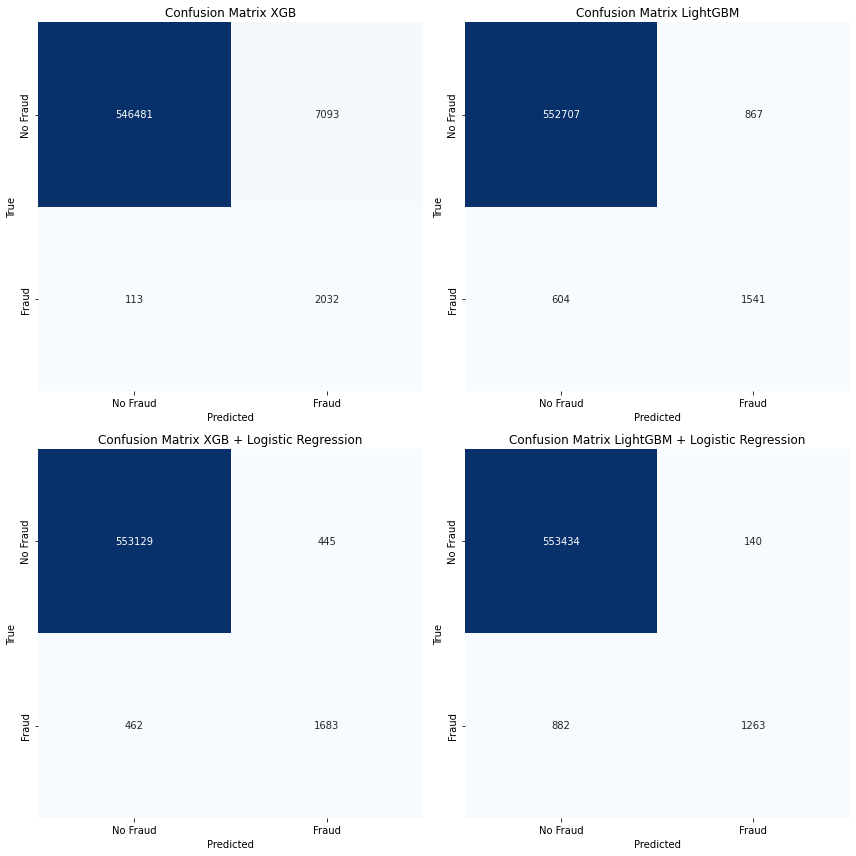

In [0]:
# List to iterate in our loop
predictions = [                                                                                # [predictions,title,prediction_column]
    (xgb_predictions, 'XGB', 'xgb_pred'),
    (gbm_predictions, 'LightGBM', 'gbm_prediction'),
    (xgb_lr_predictions, 'XGB + Logistic Regression', 'prediction'),
    (gbm_lr_predictions, 'LightGBM + Logistic Regression', 'prediction'),
]

plt.figure(figsize=(12, 12))                                                                    
i = 1                                                                                           # Iterator for each plot in subplot
for prediction, title, result in predictions:
    confusion = prediction.select(result, 'is_fraud').groupBy(result, 'is_fraud').count()       # Get predictions and true for each model
    conf_dict = {(row[result], row['is_fraud']): row['count'] for row in confusion.collect()}   # Create a dictionary

    # Metrics
    TN = conf_dict.get((0.0, 0), 0)
    FP = conf_dict.get((1.0, 0), 0)
    FN = conf_dict.get((0.0, 1), 0)
    TP = conf_dict.get((1.0, 1), 0)

    conf_matrix = np.array([[TN, FP],
                            [FN, TP]])

    accuracy = (TP + TN) / (TP + TN + FP + FN) 
    precision = TP / (TP + FP) 
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP) 
    f1_score = 2 * (precision * recall) / (precision + recall) 

    # Confusion matrix
    plt.subplot(2, 2, i)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Fraud', 'Fraud'],
                yticklabels=['No Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix {title}')
    plt.ylabel('True')
    plt.xlabel('Predicted')

    print(f'---{title}---')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Sensibility or Recall: {recall:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'F1-Score: {f1_score:.4f}\n')
    
    # Increase our iterator and next subplot
    i += 1

# Display our plot
plt.tight_layout()
plt.show()  

Conclusion for each model:

- Among the evaluated methods, XGBoost (XGB) achieved the highest recall (0.9473), making it most effective at identifying fraudulent transactions, but it suffered from very low precision (0.2227), indicating a high number of false positives. 
- LightGBM offered a better precision-recall tradeoff (precision: 0.6400, recall: 0.7184) and excellent overall accuracy (0.9974), making it more balanced but slightly less sensitive to fraud cases. 
- The combined model XGB + Logistic Regression showed the best overall performance with the highest F1-score (0.7877), maintaining a strong balance between precision (0.7909) and recall (0.7846), along with excellent accuracy (0.9984). 
- Meanwhile, LightGBM + Logistic Regression achieved the highest precision (0.9002) and specificity (0.9997), minimizing false positives significantly, but at the cost of recall (0.5888), missing a notable portion of actual frauds. 

Overall, XGB + Logistic Regression stands out as the most balanced and robust model meanwhile XGB is the best model detecting all fraud cases. In my opinion, if you are looking for a balanced model, XGB + Logistic Regression is a good choice, however in fraud detection catching fraud is more important than false alarms and them my choice is uses XGB.

